This Jupyter Notebook is used for extracting data from multiple sources. The sources include trip data, occupancy data, and parking lot data. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import os
import folium
from pathlib import Path
import boto3

# import from src
os.chdir('../src')
from trips_data_retrieval import get_agg_trips_by_market, get_agg_trips
import inrix_data_science_utils.maps.quadkey as qkey
from utils import *

# set paths
data_path = Path('../data')

### Extract the 6 Flags Polygon Shapes
#### This might be unnecessary

In [2]:
from polygon_retrieval import get_polygons

# Six Flags
brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
poly_file_name = data_path / 'six_flags_polygons.csv'

In [3]:

if not os.path.exists(poly_file_name):
    polygon_df = get_polygons(brand_id, format='df', echo_query=True)
    relevant_cols = ['location_name', 'top_category', 'sub_category', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours',
                 'category_tags', 'polygon_wkt', 'polygon_class', 'enclosed', 'is_synthetic', 'includes_parking_lot', 'wkt_area_sq_meters', 'tz', 'year',
                 'month', 'pg_id', 'parking_wkt']
    polygon_df = polygon_df[relevant_cols]
    polygon_df.to_csv(poly_file_name, index=False)
else:
    polygon_df = pd.read_csv(poly_file_name)

In [4]:
# make a new df with just the unique latitude and longitude columns
store_locations_df = polygon_df[['latitude', 'longitude', 'street_address', 'city', 'region']].drop_duplicates()
display(store_locations_df)

six_flag_stores = folium.Map(zoom_start=15)
for i, row in store_locations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='blue',
        radius=4
    ).add_to(six_flag_stores)
six_flag_stores.fit_bounds(six_flag_stores.get_bounds())
six_flag_stores

,latitude,longitude,street_address,city,region
0,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY
53,42.369309,-87.935103,542 N State Route 21,Gurnee,IL
76,38.906271,-76.776467,13710 Central Ave,Bowie,MD
148,40.141007,-74.438164,1 Six Flags Blvd,Jackson,NJ
334,32.761690,-97.081166,1800 E Lamar Blvd,Arlington,TX
355,35.463453,-97.589371,3908 W Reno Ave,Oklahoma City,OK
359,42.927651,-78.385383,9993 Alleghany Rd,Corfu,NY
403,42.245289,-88.964116,7820 Cherryvale N Blvd,Cherry Valley,IL


In [5]:
# city = 'Oklahoma City'
# test_site = store_locations_df[store_locations_df['city'] == city].iloc[0]
# test_point = test_site['latitude'], test_site['longitude']

# # get the quadkey for a specific location
# qk = qkey.QuadKey('0')
# qk = qk.from_geo(test_point, level=16)
# print(qk)
# qk.show()

#### Map the parking lots at each store

In [6]:
lot_gpd = polygon_df.copy()
geometry = lot_gpd['parking_wkt'].apply(wkt.loads)
lot_gpd = gpd.GeoDataFrame(lot_gpd, crs='epsg:4326', geometry=geometry)
print(lot_gpd.crs)
lot_gpd[lot_gpd['city'] == city].plot(figsize=(6, 6))
plt.show()

epsg:4326


NameError: name 'city' is not defined

In [ ]:
lot_map = folium.Map(zoom_start=10)
cities = lot_gpd['city'].unique()
# add pois to lot map
for city in cities:
    city_gpd = lot_gpd[lot_gpd['city'] == city].copy()
    geom = city_gpd['polygon_wkt'].values[0]
    # convert geom to a shapely geometry object
    geom = wkt.loads(geom)
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3})
    folium.Popup(city).add_to(geo_j)
    geo_j.add_to(lot_map)

# add parking lots to lot map
for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8})
    geo_j.add_to(lot_map)
print('loop done')
# lot_map

# neighbors = qk.nearby()
# neighbors.append(str(qk))
# lot_map = add_qks_to_map(lot_map, neighbors)
qk.show(lot_map)
lot_map

### Get the Parking Occupancy Ground Truth Data

In [2]:
from parking_data_retrieval import get_parking_data

Find which cities have the most parking data

In [3]:
destinations = pd.read_csv('../data/valid_parking_destinations.csv')
# sort destinations by num_lots
destinations = destinations.sort_values('num_lots', ascending=False)
display(destinations.head(25))

,pk_destination,str_name,num_lots
19,8faeea56-7a52-11df-ad8f-6b84bf453d3d,Santa Monica,15
16,8faca340-7a52-11df-8a97-875256aaa997,Irvine,11
10,8f98cf00-7a52-11df-bb23-6f961d7daa51,Ann Arbor,9
6,8f8ae430-7a52-11df-93fb-6b6334ed9a2a,Knoxville,7
15,8fa9dfde-7a52-11df-af59-273aa13aeea1,Phoenix,6
14,8fa8608c-7a52-11df-841d-870c5e91ead8,Madison,5
3,8f854570-7a52-11df-9a45-93d95744a90c,Asheville,5
18,8fae86e2-7a52-11df-b2bb-d72f2aaf97c2,Sacramento,4
5,8f8935cc-7a52-11df-85ef-037cba85cd49,Philadelphia,4
9,8f91a77a-7a52-11df-844f-c76b5ffdf7f2,Iowa City,4


In [4]:
destination_name = 'Irvine'
datetime_start = '2023-01-01'
datetime_end = '2023-01-31'

parking_filename = f'parking_{destination_name}_{datetime_start}_{datetime_end}.csv'

In [5]:
if not os.path.exists(data_path / parking_filename):
    parking_df = get_parking_data(pk_lot=None,
                                  destination_name=destination_name,
                                  datetime_start=datetime_start,
                                  datetime_end=datetime_end,
                                  echo_query=True)
    relevant_cols = ['dt_start_date', 'dt_end_date', 'i_avail', 'i_occ', 'f_pct_occ', 'pk_lot_alias',
                     'f_occupancy_rank', 'pk_lot', 'location', 'geometry']
    parking_df = parking_df[relevant_cols]
    parking_df.to_csv(data_path / parking_filename, index=False)
else:
    parking_df = pd.read_csv(data_path / parking_filename)
    parking_df['dt_start_date'] = pd.to_datetime(parking_df['dt_start_date'])
print(parking_df.shape)
parking_df.head()

(27174, 10)


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
0,2023-01-31 07:41:55.166454+00:00,2023-01-31 11:41:55.166454+00:00,184,81.0,31.0,4449d7eb-815a-4293-ab6a-2add6a19fc3c,3.0,90394,POINT(-117.859954615167 33.6817585441798),"MULTIPOLYGON(((-117.86031 33.68066,-117.86083 ..."
1,2023-01-31 07:41:55.137835+00:00,2023-01-31 11:41:55.137835+00:00,174,248.0,59.0,35012bdd-88f0-470d-a710-6513579ac35e,3.0,90394,POINT(-117.859954615167 33.6817585441798),"MULTIPOLYGON(((-117.86031 33.68066,-117.86083 ..."
2,2023-01-31 07:41:55.109223+00:00,2023-01-31 11:41:55.109223+00:00,43,294.0,87.0,10a84b43-9a9c-4b78-8539-a48121f1eae9,3.0,90394,POINT(-117.859954615167 33.6817585441798),"MULTIPOLYGON(((-117.86031 33.68066,-117.86083 ..."
3,2023-01-31 07:41:55.079620+00:00,2023-01-31 11:41:55.079620+00:00,254,193.0,43.0,6e504244-38c2-4657-ac01-cd1fb94e497d,3.0,90394,POINT(-117.859954615167 33.6817585441798),"MULTIPOLYGON(((-117.86031 33.68066,-117.86083 ..."
4,2023-01-31 06:56:32.707441+00:00,2023-01-31 10:56:32.707441+00:00,178,87.0,33.0,4449d7eb-815a-4293-ab6a-2add6a19fc3c,3.0,90394,POINT(-117.859954615167 33.6817585441798),"MULTIPOLYGON(((-117.86031 33.68066,-117.86083 ..."


In [6]:
parking_gpd = parking_df.copy()
geometry = parking_gpd['geometry'].apply(wkt.loads)
parking_gpd = gpd.GeoDataFrame(parking_gpd, crs='epsg:4326', geometry=geometry)

In [7]:
# get the quadkey for a specific location
lot_gpd = parking_gpd.groupby('pk_lot').agg({'geometry': 'first'}).reset_index()
qk = qkey.QuadKey('0')
level = 15
lot_gpd['centroid'] = lot_gpd['geometry'].apply(lambda x: x.centroid)
lot_gpd['center_lat'] = lot_gpd['centroid'].apply(lambda x: x.coords[0][1])
lot_gpd['center_lon'] = lot_gpd['centroid'].apply(lambda x: x.coords[0][0])
lot_gpd['qk'] = lot_gpd.apply(lambda row: qk.from_geo((row['center_lat'], row['center_lon']), level=level), axis=1)
display(lot_gpd)

,pk_lot,geometry,centroid,center_lat,center_lon,qk
0,90391,"MULTIPOLYGON (((-117.86 33.682, -117.86 33.682...",POINT (-117.86 33.681),33.680988,-117.859470,023013202011200
1,90393,"MULTIPOLYGON (((-117.86 33.678, -117.86 33.676...",POINT (-117.86 33.677),33.677228,-117.861826,023013202010313
2,90394,"MULTIPOLYGON (((-117.86 33.681, -117.86 33.681...",POINT (-117.86 33.682),33.681759,-117.859955,023013202011200
3,90399,"MULTIPOLYGON (((-117.86 33.686, -117.86 33.686...",POINT (-117.86 33.687),33.686632,-117.861929,023013202010311
4,209634,"MULTIPOLYGON (((-117.86 33.675, -117.86 33.674...",POINT (-117.86 33.675),33.675442,-117.863799,023013202010313
5,329825,"MULTIPOLYGON (((-117.74 33.648, -117.74 33.648...",POINT (-117.74 33.648),33.647946,-117.742667,023013202102010
6,375750,"MULTIPOLYGON (((-117.74 33.648, -117.74 33.648...",POINT (-117.74 33.649),33.648507,-117.739902,023013202102011
7,380308,"MULTIPOLYGON (((-117.74 33.65, -117.74 33.649,...",POINT (-117.74 33.649),33.648843,-117.744097,023013202102010
8,381380,"MULTIPOLYGON (((-117.74 33.651, -117.74 33.651...",POINT (-117.74 33.651),33.650946,-117.741555,023013202102010
9,381381,"MULTIPOLYGON (((-117.74 33.653, -117.74 33.652...",POINT (-117.74 33.652),33.652313,-117.743548,023013202100232


In [8]:
# folium plot the parking lots
m = folium.Map(zoom_start=10)

for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8},
                           tooltip=r['pk_lot'])

    geo_j.add_to(m)


for q in lot_gpd['qk'].unique():
    polygon = folium.GeoJson(data=q.get_bounds_as_geojson(),
                             style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3},
                             tooltip=str(q))
    polygon.add_to(m)


m

#### Parking Occupancy Initial Plots

In [9]:
print(parking_df['pk_lot'].unique())

[ 90394 209634  90391 381380  90393  90399 329825 380308 387459 381381
 375750]


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
9848,2023-01-01 08:21:39.613844+00:00,2023-01-01 12:21:39.613844+00:00,305,127.0,29.0,5b32933a-f041-443b-a432-4a08d17e5cf9,3.0,209634,POINT(-117.863799180098 33.6754421700777),"MULTIPOLYGON(((-117.86341 33.67456,-117.86395 ..."
9847,2023-01-01 08:21:39.646652+00:00,2023-01-01 12:21:39.646652+00:00,36,272.0,88.0,f896d44e-b500-43af-a47a-8426004628a3,3.0,209634,POINT(-117.863799180098 33.6754421700777),"MULTIPOLYGON(((-117.86341 33.67456,-117.86395 ..."
9846,2023-01-01 08:21:39.677868+00:00,2023-01-01 12:21:39.677868+00:00,349,85.0,20.0,c411967e-2ca7-4d79-8842-af1afeb70155,3.0,209634,POINT(-117.863799180098 33.6754421700777),"MULTIPOLYGON(((-117.86341 33.67456,-117.86395 ..."
9845,2023-01-01 08:21:39.708443+00:00,2023-01-01 12:21:39.708443+00:00,246,58.0,19.0,629281c6-2f30-4c20-8534-9a30fcf4ccd3,3.0,209634,POINT(-117.863799180098 33.6754421700777),"MULTIPOLYGON(((-117.86341 33.67456,-117.86395 ..."
9844,2023-01-01 08:46:01.400664+00:00,2023-01-01 12:46:01.400664+00:00,305,127.0,29.0,5b32933a-f041-443b-a432-4a08d17e5cf9,3.0,209634,POINT(-117.863799180098 33.6754421700777),"MULTIPOLYGON(((-117.86341 33.67456,-117.86395 ..."


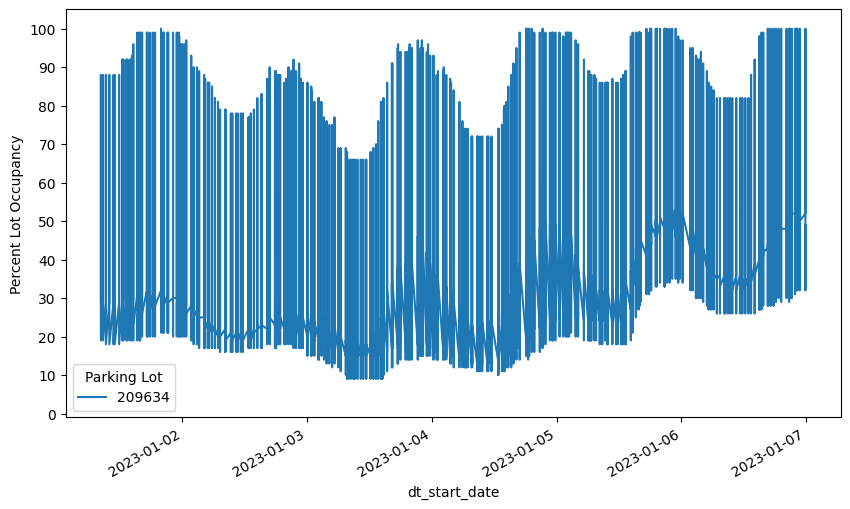

In [10]:
# line graph of f_pct_occ vs. dt_start_date grouped by pk_lot
day_df = parking_df[(parking_df['dt_start_date'] >= '2023-01-01') &
                    (parking_df['dt_start_date'] <= '2023-01-7') &
                    (parking_df['pk_lot'] == 209634)]
# order day_df by dt_start_date
day_df = day_df.sort_values('dt_start_date')
display(day_df.head(5))

plt.figure(figsize=(10, 6))
day_df.set_index('dt_start_date', inplace=True)
day_df.groupby('pk_lot')['f_pct_occ'].plot(legend=True)
# plt.plot(day_df['dt_start_date'], day_df['f_pct_occ'])
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Percent Lot Occupancy')
plt.legend(title='Parking Lot')
plt.ylim(-1, 105)
plt.show()


Smooth into 1 minute buckets

In [11]:
parking_df['dt_start_date'] = pd.to_datetime(parking_df['dt_start_date'])
print(parking_df['dt_start_date'].dtype)

datetime64[ns, UTC]


In [12]:
smooth_df = parking_df.sort_values('dt_start_date').copy()
smooth_df['time_bucket'] = smooth_df['dt_start_date'].dt.floor('min')
agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
            'location': 'first', 'geometry': 'first',}
grouped_df = smooth_df.groupby(['pk_lot', 'time_bucket']).agg(agg_dict).reset_index()
# how many rows from the original go into each group of grouped_df

a, b = smooth_df.shape[0], grouped_df.shape[0]
print(f'At least {a - b} rows out of {a} from the original\ndf go into each group of grouped_df for a final size of {b}')
display(grouped_df)

At least 13262 rows out of 27174 from the original
df go into each group of grouped_df for a final size of 13912


,pk_lot,time_bucket,f_pct_occ,i_avail,i_occ,location,geometry
0,90391,2023-01-01 08:21:00+00:00,31.333333,356.666667,160.000000,POINT(-117.859470364962 33.6809876250827),"MULTIPOLYGON(((-117.85839 33.68227,-117.85834 ..."
1,90391,2023-01-01 08:46:00+00:00,31.333333,357.333333,159.333333,POINT(-117.859470364962 33.6809876250827),"MULTIPOLYGON(((-117.85839 33.68227,-117.85834 ..."
2,90391,2023-01-01 09:19:00+00:00,31.333333,357.666667,159.000000,POINT(-117.859470364962 33.6809876250827),"MULTIPOLYGON(((-117.85839 33.68227,-117.85834 ..."
3,90391,2023-01-01 09:59:00+00:00,31.333333,357.333333,159.333333,POINT(-117.859470364962 33.6809876250827),"MULTIPOLYGON(((-117.85839 33.68227,-117.85834 ..."
4,90391,2023-01-01 10:47:00+00:00,31.333333,358.000000,158.666667,POINT(-117.859470364962 33.6809876250827),"MULTIPOLYGON(((-117.85839 33.68227,-117.85834 ..."
...,...,...,...,...,...,...,...
13907,387459,2023-01-31 03:05:00+00:00,34.000000,950.000000,NaN,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON(((-117.739180228 33.648147941,-11..."
13908,387459,2023-01-31 03:23:00+00:00,34.000000,950.000000,NaN,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON(((-117.739180228 33.648147941,-11..."
13909,387459,2023-01-31 05:13:00+00:00,30.000000,1010.000000,NaN,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON(((-117.739180228 33.648147941,-11..."
13910,387459,2023-01-31 05:14:00+00:00,30.000000,1010.000000,NaN,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON(((-117.739180228 33.648147941,-11..."


In [13]:
grouped_df.to_csv(data_path / 'IrvineSpectrumCenter_parking.csv', index=False)

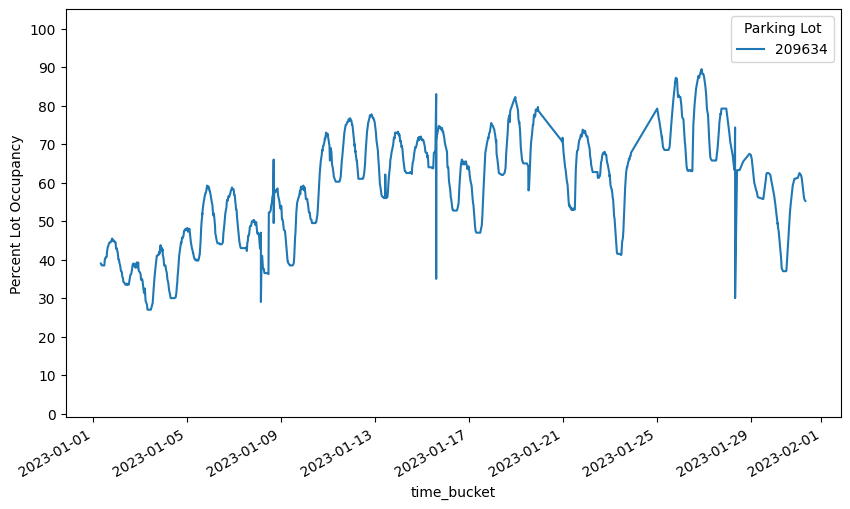

In [14]:
sanity_check = grouped_df[grouped_df['pk_lot'] == 209634] # grouped_df
sanity_check = sanity_check.sort_values('time_bucket')
# display(sanity_check)

plt.figure(figsize=(10, 6))
sanity_check.set_index('time_bucket', inplace=True)
sanity_check.groupby('pk_lot')['f_pct_occ'].plot(legend=True)
# plt.plot(day_df['dt_start_date'], day_df['f_pct_occ'])
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Percent Lot Occupancy')
plt.legend(title='Parking Lot')
plt.ylim(-1, 105)
plt.show()

### Extracting Trips

In [19]:
# Change these as needed
# qk_list = ['02123003']  # seattle area
# qk_list = ['021230032110033003', '021230032110033012', '021230032110033021', '021230032110033030']  # QFC North Bend
# qk_list = [str(qk)]  # Six Flags OKC
# qk_list = neighbors  # if we want to get all the neighbors data too
qk_list = ['023013202100232', '023013202100233', '023013202102010', '023013202102011'] # 
start_date = pd.to_datetime('2023-01-01 00:00:00')
end_date = pd.to_datetime('2023-1-31 00:01:00')
trip_type = 'orig' # 'orig' or 'dest'
filename_description = 'IrvineSpectrumCenter'

# don't change these
start_year = str(start_date.year)
start_month = str(start_date.month).zfill(2)
start_day = str(start_date.day).zfill(2)
end_year = str(end_date.year)
end_month = str(end_date.month).zfill(2)
end_day = str(end_date.day).zfill(2)
out_filename = f'''{trip_type}_trips_{filename_description}_{start_year}-{start_month}-{start_day}_to_{
                end_year}-{end_month}-{end_day}.csv'''
out_file_path = data_path / out_filename
print('Will save the csv to ', out_file_path)
origin_qk = (trip_type == 'orig')

table_name = 'tripdata_na_restricted'
s3_tapp_data_dir = 'data-restricted'
s3_tapp_region = 'NA'

Will save the csv to  ..\data\orig_trips_IrvineSpectrumCenter_2023-01-01_to_2023-01-31.csv


In [20]:
# if out_file_path not in the data folder, save it there
if not os.path.exists(out_file_path):
    trips_df = get_agg_trips(
        agg_file_path = out_file_path,
        echo_query=True,
        table_name=table_name,
        start_date=start_date,
        end_date=end_date,
        qk_filter_list=qk_list,
        s3_tapp_data_dir=s3_tapp_data_dir,
        s3_tapp_region=s3_tapp_region,
        origin_qk=origin_qk,
    )
    print('Saved the csv to', out_file_path)
else:
    trips_df = pd.read_csv(out_file_path)

trips_df['date'] = pd.to_datetime(trips_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
display(trips_df)


            WITH qk_counts AS(
            SELECT start_time, provider, start_lat, start_lon, end_lat, end_lon, 
                    BING_TILE_QUADKEY(BING_TILE_AT(end_lat, end_lon, 17)) AS dest_qk17,
                    BING_TILE_QUADKEY(BING_TILE_AT(start_lat, start_lon, 17)) AS orig_qk17,
                    year, month, day, SUBSTR(start_time,12, 2) AS hour, SUBSTR(start_time, 15, 2) AS minute,
                    SUBSTR(start_time, 18, 2) AS second, trip_id, is_moving

            FROM "inrixdatascience"."tripdata_na_restricted"
            WHERE
                qk = '02301'
                AND CAST(year as INT) BETWEEN 2023 AND 2023
                AND CAST(month as INT) BETWEEN 1 AND 1
                AND CAST(day AS INT) BETWEEN 1 AND 31
                AND provider IN ('475', '458', '470')
                AND REGEXP_LIKE(
                        BING_TILE_QUADKEY(BING_TILE_AT(start_lat, start_lon, 15)),
                        '(023013202100232|023013202100233|023013202102010

,start_time,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving,date
0,2023-01-11 15:54:09.000,2023,01,11,15,54,09,02301320210023222,02301320210210230,33.653279,-117.750363,33.636620,-117.722561,1,27405670aaeafc631fe7fda4abc29778,1,2023-01-11 15:54:09
1,2023-01-01 18:20:23.000,2023,01,01,18,20,23,02301320210023222,02301320210023302,33.651382,-117.750726,33.656131,-117.740339,1,de941b6818a4668f33f519b808567e7b,1,2023-01-01 18:20:23
2,2023-01-01 21:47:45.000,2023,01,01,21,47,45,02301320210201012,02301320210302233,33.648475,-117.743842,33.614908,-117.676453,1,b4305ed8c46ef6887e9a229efa3bbc80,1,2023-01-01 21:47:45
3,2023-01-06 00:38:25.000,2023,01,06,00,38,25,02301320210023223,02301231130231103,33.652237,-117.747487,33.904067,-118.396029,1,8b6df83fa60a913786a81c0e707c7efd,1,2023-01-06 00:38:25
4,2023-01-06 04:32:09.000,2023,01,06,04,32,09,02301320210201010,02301320210212120,33.649091,-117.744615,33.626152,-117.715859,1,312839728a6fb5fa7fb2d15e7a79e1fb,1,2023-01-06 04:32:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44913,2023-01-10 18:57:11.000,2023,01,10,18,57,11,02301320210201010,02301320023210302,33.649208,-117.743964,33.785225,-117.892766,1,da599708e1cdd7045c2af242e5f306f6,1,2023-01-10 18:57:11
44914,2023-01-10 22:42:02.000,2023,01,10,22,42,02,02301320210201030,02301320210120212,33.645427,-117.743530,33.675128,-117.679907,1,55b13722fa666f040de58f01e4f30109,1,2023-01-10 22:42:02
44915,2023-01-05 23:06:28.000,2023,01,05,23,06,28,02301320210201103,02301320212130330,33.648287,-117.735703,33.525673,-117.622739,1,9cbc002ecc1935ce412d46c3ce252ea4,1,2023-01-05 23:06:28
44916,2023-01-18 04:34:59.000,2023,01,18,04,34,59,02301320210201012,02301320212033113,33.648893,-117.743776,33.520629,-117.688290,1,b64721d1254a366d5208d3985c8169e5,1,2023-01-18 04:34:59


In [38]:
# m = lot_map
# m = folium.Map(zoom_start=10)
map = m

N = 10
for i in range(0, trips_df.shape[0], N):
    folium.CircleMarker(
        location=[
            trips_df['end_lat'].values[i],
            trips_df['end_lon'].values[i]
        ],
        color='red',
        radius=1
    ).add_to(map)
# m.fit_bounds(m.get_bounds())

# for i in range(0, trips_df.shape[0], N):
#     folium.CircleMarker(
#         location=[
#             trips_df['start_lat'].values[i],
#             trips_df['start_lon'].values[i]
#         ],
#         color='blue',
#         radius=1
#     ).add_to(map)
# m.fit_bounds(m.get_bounds())

map